In [1]:
import numpy as np
import pandas as pd
import time
import os.path
import pickle
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

In [2]:
import numba as nb

@nb.njit(parallel=True)
def fastSort(a):
    b = np.empty(a.shape, dtype=np.int32)
    for i in nb.prange(a.shape[1]):
        b[:,i] = np.argsort(a[:,i])
    return b

def acc(P):
    """ accumulate matrix """
    for i in range(1, P.shape[0]):
        P[i] += P[i-1]
    return None
    
def ES(list_gene, profile):
    """ KS enrichment score"""
    if len(list_gene) == 0:
        return 0
    N, M = profile.shape[0], profile.shape[1]
    index = fastSort(-profile)
    rank = fastSort(index)
    # connectivity score in L1000 paper
    Nh = len(list_gene)
    Nr = np.zeros(M)
    P_hit = np.zeros((N, M))
    P_miss = np.ones((N, M))
    temp = np.array(range(M))
    profile = profile[index, temp]
    for i in list_gene:
        P_hit[rank[i], temp] = np.abs(profile[rank[i], temp])
        P_miss[rank[i], temp] = 0
        Nr += np.abs(profile[rank[i], temp])
    P_hit /= Nr
    P_miss /= N - Nh
    acc(P_hit)
    acc(P_miss)
    ES_score_all = P_hit - P_miss
    ES_score = ES_score_all[np.abs(ES_score_all).argmax(0), temp]

    return ES_score, ES_score_all


In [3]:
gene_exp = pd.read_csv('gene_expression_full.csv')
gene_exp

,geneID,test,log2FoldChange,pvalue,From,Gene Names,Gene Name
0,A1bg,group2/group1,0.00,1.000000,A1bg,A1BG,A1BG
1,A1cf,group2/group1,0.00,1.000000,A1cf,A1CF ACF ASP,A1CF
2,A2m,group2/group1,0.00,1.000000,A2m,A2M CPAMD5 FWP007,A2M
3,A3galt2,group2/group1,0.00,1.000000,A3galt2,A3GALT2 A3GALT2P IGBS3S,A3GALT2
4,A4galt,group2/group1,0.00,1.000000,A4galt,A4GALT A14GALT A4GALT1,A4GALT
...,...,...,...,...,...,...,...
16534,Zyg11a,group2/group1,0.00,1.000000,Zyg11a,ZYG11A ZYG11,ZYG11A
16535,Zyg11b,group2/group1,0.89,0.675590,Zyg11b,ZYG11B KIAA1730,ZYG11B
16536,Zyx,group2/group1,-0.06,0.854100,Zyx,ZYX,ZYX
16537,Zzef1,group2/group1,-1.11,0.409474,Zzef1,ZZEF1 KIAA0399,ZZEF1


In [4]:
gene2idx = {}
for i,j in enumerate(gene_exp['Gene Name'].values):
    gene2idx[j] = i

In [5]:
X = gene_exp['log2FoldChange'].values.reshape(1, -1)

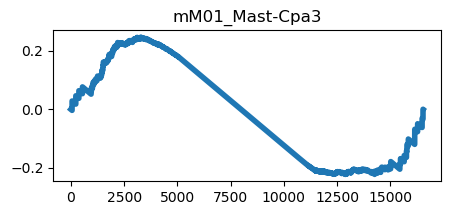

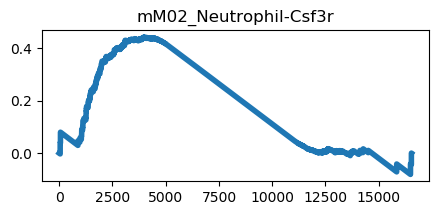

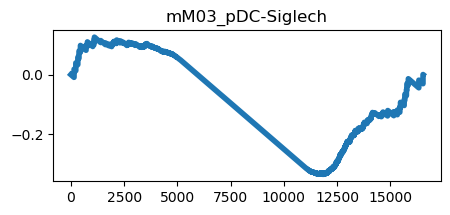

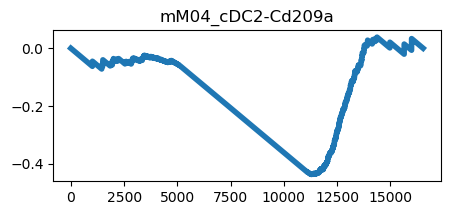

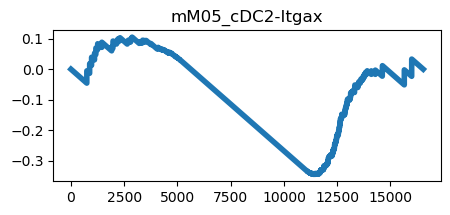

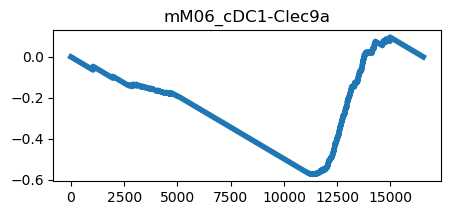

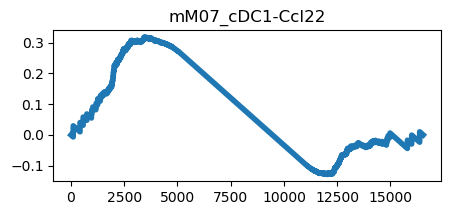

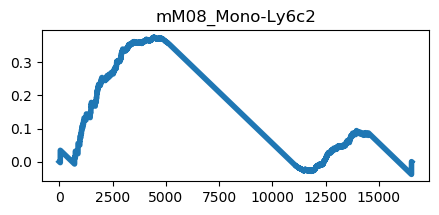

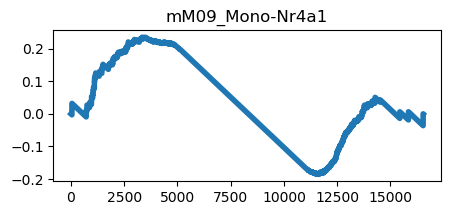

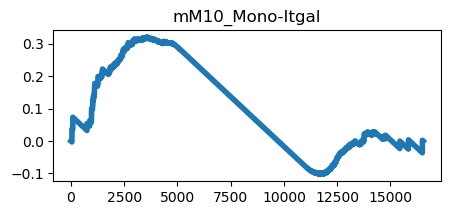

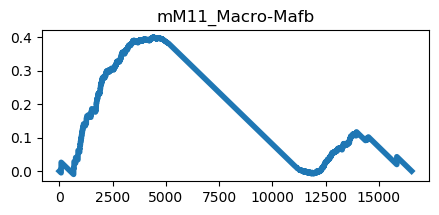

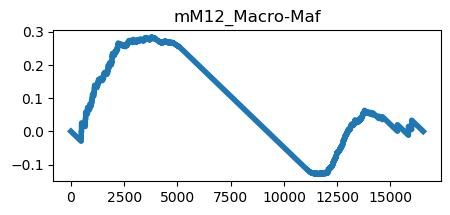

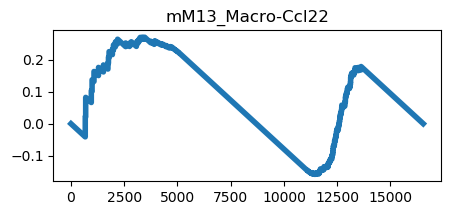

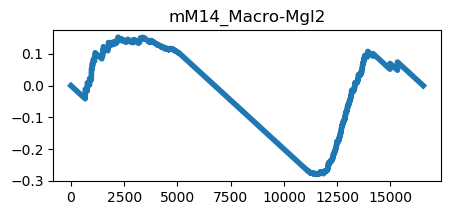

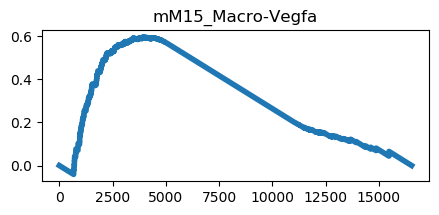

In [6]:
table_results = pd.DataFrame(columns=['Cell', 'Enrichment Score', '#Gene set', '#Up', '#Down'])
for frame in range(1):
    table = pd.read_excel('_____2020-Cell-Single-Cell Analyses Inform Mechanisms of Myeloid-Targeted Therapies in Colon Cancer.xlsx', 
                          frame=frame,
                          skiprows=2)
    table = table.dropna()
    columns = table.columns.values
    columns[0:4] = ['Gene name', 'Myeloid cluster', 'AUC', 'F']
    table.columns = columns
    list_cluster = table['Myeloid cluster'].unique()
    for c in list_cluster:
#         if 'DC' not in c:
#             continue
        index = table['Myeloid cluster'] == c
        list_gene_temp = np.unique([item.upper() for item in table[index]['Gene name']])
        gene_idx = [gene2idx[gene] for gene in list_gene_temp if gene in gene2idx]
        es, es_all = ES(gene_idx, X.T)
        table_results.loc[len(table_results)] = [c, es[0], len(gene_idx), np.sum(X[0][gene_idx]>0), np.sum(X[0][gene_idx]<0)]
        plt.figure(dpi=100, figsize=(5, 2))
        plt.plot(es_all.reshape(-1), lw=4)
        plt.title(c)
        plt.show()
table_results = table_results.drop_duplicates()

In [7]:
table_results.sort_values('Enrichment Score', ascending=False)

,Cell,Enrichment Score,#Gene set,#Up,#Down
14,mM15_Macro-Vegfa,0.594627,244,182,61
1,mM02_Neutrophil-Csf3r,0.442051,232,145,80
10,mM11_Macro-Mafb,0.400843,406,222,181
7,mM08_Mono-Ly6c2,0.375460,369,193,174
9,mM10_Mono-Itgal,0.320849,304,131,167
6,mM07_cDC1-Ccl22,0.317395,284,128,150
11,mM12_Macro-Maf,0.283844,370,152,213
12,mM13_Macro-Ccl22,0.269737,158,45,110
0,mM01_Mast-Cpa3,0.246975,258,113,130
8,mM09_Mono-Nr4a1,0.235815,396,148,242
